In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import shutil

## 데이터 전처리

In [62]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")


In [73]:
#유저 여러명 데이터 모으기
base_dir=os.getenv("HOME")+'/aiffel/Exploration/EX1/data/other_users/'
members = ['정우', '진영', '현지', '서현']
# members = os.listdir(base_dir)
categories = ['rock', 'scissor', 'paper']
base_dst = os.getenv("HOME")+'/aiffel/Exploration/EX1/data/data_all_users/'

for member in members:
    for category in categories:
        path = os.path.join(base_dir, member, category)
        for image in os.listdir(path):
            if ".jpg" in image:
                image_rename = member + '_' + image
                image_path_src = os.path.join(base_dir, member, category, image)
                image_path_dst = os.path.join(base_dst, category, image_rename)
                shutil.copyfile(image_path_src, image_path_dst)



#본인 데이터 트레인 셋에 추가
base_dir = os.getenv("HOME")+'/aiffel/Exploration/EX1/data/rock_scissor_paper'
for category in categories:
    path = os.path.join(base_dir, category)
    for image in os.listdir(path):
        if '.jpg' in image:
            image_rename = '현빈_' + image
            image_path_src = os.path.join(base_dir, category, image)
            image_path_dst = os.path.join(base_dst, category, image_rename)
            shutil.copyfile(image_path_src, image_path_dst)
            
            
print(f"총 {len(members)+1}명의 데이터가 모였습니다!!")

for category in categories:
    print(f"{category}에 {len(os.listdir(base_dst+category))}개 ")

총 5명의 데이터가 모였습니다!!
rock에 501개 
scissor에 501개 
paper에 501개 


In [64]:
#학습 데이터 크기 28x28로 조정
for class_ in ["rock", "scissor", "paper"]:
    image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/EX1/data/data_all_users/" + class_
    resize_images(image_dir_path)

500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.


## 데이터 읽어오기

In [65]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels



In [66]:
image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/EX1/data/data_all_users"
(x_train, y_train)=load_data(image_dir_path, (len(members)+1)*300) #추가한 사진들의 수에 맞게
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1500 입니다.
x_train shape: (1500, 28, 28, 3)
y_train shape: (1500,)


### 이미지 확인하기

라벨:  0


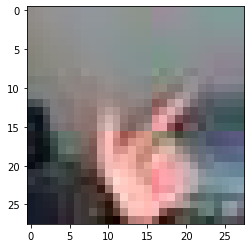

In [74]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 모델 설계

In [117]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(128, (3,3), input_shape=(28,28,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.Conv2D(64, (3,3), activation='swish'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(32, (3,3) ))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.Conv2D(32, (3,3), activation='swish'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(n_dense, activation='relu'))

model.add(keras.layers.Dense(64, activation='swish'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='swish'))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 128)       3584      
_________________________________________________________________
batch_normalization_28 (Batc (None, 26, 26, 128)       512       
_________________________________________________________________
activation_22 (Activation)   (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 24, 24, 64)        73792     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 10, 10, 32)        18464     
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 10, 32)      

## 모델 학습

In [118]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
#콜백 함수
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

# 모델 훈련
model.fit(x_train_norm, y_train, callbacks = [model_checkpoint_callback], epochs=13)
model.load_weights(checkpoint_filepath)


Epoch 1/13
47/47 [==============================] - 1s 8ms/step - loss: 1.0282 - accuracy: 0.4573
Epoch 2/13
47/47 [==============================] - 0s 7ms/step - loss: 0.7557 - accuracy: 0.6587
Epoch 3/13
47/47 [==============================] - 0s 7ms/step - loss: 0.6004 - accuracy: 0.7393
Epoch 4/13
47/47 [==============================] - 0s 7ms/step - loss: 0.4653 - accuracy: 0.8087
Epoch 5/13
47/47 [==============================] - 0s 7ms/step - loss: 0.3426 - accuracy: 0.8660
Epoch 6/13
47/47 [==============================] - 0s 7ms/step - loss: 0.2608 - accuracy: 0.9013
Epoch 7/13
47/47 [==============================] - 0s 7ms/step - loss: 0.2596 - accuracy: 0.9033
Epoch 8/13
47/47 [==============================] - 0s 7ms/step - loss: 0.1814 - accuracy: 0.9313
Epoch 9/13
47/47 [==============================] - 0s 7ms/step - loss: 0.1415 - accuracy: 0.9460
Epoch 10/13
47/47 [==============================] - 0s 7ms/step - loss: 0.0868 - accuracy: 0.9687
Epoch 11/13
47/47 [

## Test Data 준비

In [106]:
#Resizing
for class_ in ["rock", "scissor", "paper"]:
    image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/EX1/data/rock_scissor_paper_given/test/" + class_
    resize_images(image_dir_path)
    

#Loading                  
image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/EX1/data/rock_scissor_paper_given/test"
                  
(x_test, y_test)=load_data(image_dir_path, 300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## 모델 평가

In [119]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.3894 - accuracy: 0.7167
test_loss: 1.3893829584121704 
test_accuracy: 0.7166666388511658
